# Potencial Ornitológico Fueguino
### **Autor:** Pablo Jusim

# Script principal del modelado

En este script se realizará la **creación**, **entrenamiento** y **evaluación** del modelo de aprendizaje automático.

### **Objetivo**
Clasificar cada área de la provincia de Tierra del Fuego según su potencial ornitológico.

Se utilizarán módulos de Python creados para este proyecto además de módulos de terceros.

El preprocesamiento de los datos se realizará en otros notebook (01a, 01b y 02) dentro de este proyecto.

El producto obtenido del modelado se continua procesando en otro notebook (03) para generar la grilla espacial final. El producto final del trabajo es un mapa que se genera en Qgis a partir de la griila obtenida mediante el modelo.


## Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import  normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
import geopandas as gpd
from pathlib import Path
import sys


# Modulos propios
sys.path.append(str(Path('..')/'src'))

import utils

## Carga de datos

In [2]:
ruta_registros = '../data/interim/grilla_tdf_spp.csv'
try:
    df = pd.read_csv(ruta_registros)
except FileNotFoundError:
    print('No se encuentra el archivo en la ruta ' + ruta_registros)

## Preprocesamiento

### Métricas exploratorias

#### Forma de los datos

In [3]:
print(f'celdas: {df.shape[0]}  /  especies: {df.shape[1]}')
print(df.columns.values)

celdas: 393  /  especies: 179
['grid_id' 'Anairetes parulus' 'Anarhynchus falklandicus'
 'Anas bahamensis' 'Anas flavirostris' 'Anas georgica' 'Anser anser'
 'Anthus correndera' 'Aphrastura spinicauda' 'Aptenodytes patagonicus'
 'Ardea ibis' 'Ardenna gravis' 'Ardenna grisea' 'Arenaria interpres'
 'Asio flammeus' 'Asthenes anthoides' 'Astur chilensis'
 'Attagis malouinus' 'Bubo magellanicus' 'Buteo ventralis' 'Calidris alba'
 'Calidris bairdii' 'Calidris canutus' 'Calidris fuscicollis'
 'Calidris himantopus' 'Calidris melanotos' 'Calidris pusilla'
 'Calidris virgata' 'Campephilus magellanicus' 'Caracara plancus'
 'Cathartes aura' 'Charadrius semipalmatus' 'Chionis albus'
 'Chloephaga hybrida' 'Chloephaga picta' 'Chloephaga poliocephala'
 'Chloephaga rubidiceps' 'Chroicocephalus maculipennis'
 'Cinclodes antarcticus' 'Cinclodes fuscus' 'Cinclodes oustaleti'
 'Cinclodes patagonicus' 'Circus cinereus' 'Cistothorus platensis'
 'Colorhamphus parvirostris' 'Columba livia' 'Coscoroba coscoroba

Si bien los datos contienen una gran cantidad de columnas (179), no se utiliza análisis de componenentes principales para reducir la dimensionalidad dado que la capacidad computacional es suficiente para procesar los modelos y se busca no perder información.

#### Métricas por celda

In [4]:
spp_cols = df.columns.drop('grid_id')
# Cantidad total de registros por celda
df['total_registros'] = df[spp_cols].sum(axis=1)
# Riqueza = cantidad de especies con al menos 1 registro
df['riqueza'] = (df[spp_cols] > 0).sum(axis=1)

print('Cantidad total de registros por celda')
print(df['total_registros'])
print('')

print('Riqueza') # Cantidad de especies (spp) con al menos 1 registro
print(df['riqueza'])


Cantidad total de registros por celda
0      170
1      189
2      179
3       19
4      555
      ... 
388     15
389     19
390      2
391    586
392    264
Name: total_registros, Length: 393, dtype: int64

Riqueza
0      48
1      51
2      57
3      19
4      70
       ..
388     3
389    15
390     1
391    50
392    41
Name: riqueza, Length: 393, dtype: int64


In [5]:
# Métricas de riqueza de especies
print(f'Riqueza media: {df['riqueza'].mean()}')
print(f'Riqueza mediana: {df['riqueza'].median()}')
print(f'Riqueza mínima: {df['riqueza'].min()}')
print(f'Riqueza máxima: {df['riqueza'].max()}')

Riqueza media: 27.41730279898219
Riqueza mediana: 19.0
Riqueza mínima: 1
Riqueza máxima: 144


La riqueza mediana es inferior a la media, lo que indica que hay celdas con valores extremos altos de riqueza.

### Gráficos exploratorios

#### Distribución de registros

###### Histograma de total de registros por celda

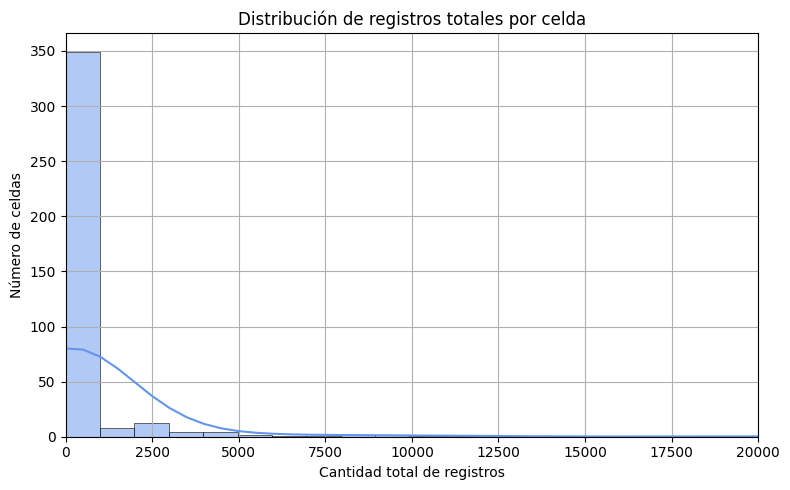

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['total_registros'], bins=100, kde=True, color='cornflowerblue')
plt.xlim(0, 20000)
plt.title("Distribución de registros totales por celda")
plt.xlabel("Cantidad total de registros")
plt.ylabel("Número de celdas")
plt.grid(True)
plt.tight_layout()
plt.show()


La cantidad de registros por celda es menor a 1000 en la gran mayoría de las celdas.

###### Histograma de riqueza por celda

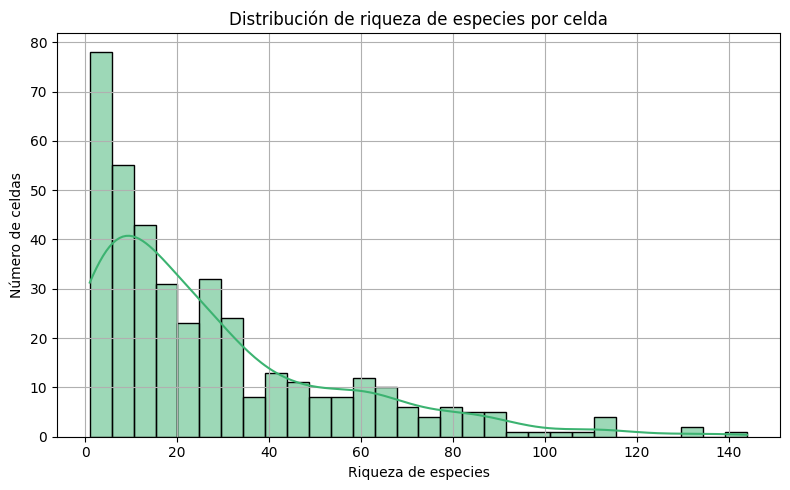

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df['riqueza'], bins=30, kde=True, color='mediumseagreen')
plt.title("Distribución de riqueza de especies por celda")
plt.xlabel("Riqueza de especies")
plt.ylabel("Número de celdas")
plt.grid(True)
plt.tight_layout()
plt.show()


La mayor parte de las celdas con requistros tienen una baja cantidad de especies

### Borrar especies muy comunes o muy raras
Las especies presentes en más de un 90% de las celdas o en menos de un 2% de las celdas se consideran muy comunes o muy raras. Las borro para mejorar el modelado.

In [8]:
# Convertir 'grid_id' en índice:
df_ind = df.set_index('grid_id')

freq_rel = (df_ind > 0).sum(axis=0) / len(df_ind)
umbral_inf, umbral_sup = 0.02, 0.90
especies_útiles = freq_rel[(freq_rel >= umbral_inf) & (freq_rel <= umbral_sup)].index
df_idx = df_ind[especies_útiles]

### TF-IDF
Destaca las especies más raras y disminuye el efecto de las más comunes, para favorecer la diferenciación de las celdas al formase los clusters.

Se normaliza el resultado obtenido

In [9]:
# Separar la matriz de valores (sin índice) para pasar a TfidfTransformer
X = df_idx.values  # shape = (n_celdas, n_especies)

# Crear y ajustar el transformador TF–IDF
tfidf = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
X_tfidf = tfidf.fit_transform(X).toarray()  # array NumPy, idéntica forma que X

# Normalizar cada fila para usar cosine distance
X_norm = normalize(X_tfidf, norm='l2', axis=1)

# 'Envolver' el array normalizado en un DataFrame que recupere el índice original
#  y los nombres de especie como columnas.
df_tfidf = pd.DataFrame(
    X_norm,
    index=df_idx.index,       # los grid_id originales
    columns=df_idx.columns    # nombres de especies
)


df_tfidf.head()


,Anairetes parulus,Anarhynchus falklandicus,Anas bahamensis,Anas flavirostris,Anas georgica,Anthus correndera,Aphrastura spinicauda,Aptenodytes patagonicus,Ardea ibis,Ardenna gravis,...,Tringa melanoleuca,Troglodytes musculus,Turdus falcklandii,Tyto furcata,Upucerthia dumetaria,Vanellus chilensis,Vultur gryphus,Zenaida auriculata,Zonibyx modestus,Zonotrichia capensis
grid_id,,,,,,,,,,,,,,,,,,,,,
25,0.000000,0.0,0.0,0.000000,0.019785,0.021280,0.000000,0.000000,0.0,0.150185,...,0.0,0.019331,0.017067,0.0,0.0,0.034545,0.019523,0.0,0.023789,0.014640
26,0.127041,0.0,0.0,0.089137,0.095427,0.034213,0.157463,0.000000,0.0,0.000000,...,0.0,0.155400,0.137202,0.0,0.0,0.055540,0.000000,0.0,0.076495,0.117688
27,0.000000,0.0,0.0,0.026418,0.056565,0.060841,0.084003,0.049078,0.0,0.107347,...,0.0,0.082903,0.073195,0.0,0.0,0.049383,0.083726,0.0,0.068014,0.062784
28,0.274709,0.0,0.0,0.000000,0.000000,0.000000,0.204295,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.248116,0.152691
70,0.014261,0.0,0.0,0.070043,0.149971,0.138264,0.042423,0.000000,0.0,0.020329,...,0.0,0.146534,0.138615,0.0,0.0,0.074816,0.000000,0.0,0.025761,0.110973


## Modelado

#### Preparar los datos para guardar los resultados de los modelos

In [11]:
# Copiar los datos para no modificar los datos preprocesados
X = df_tfidf.copy()
# Almacenar los nombres de las celdas
id_grid = X.index

# Cargar la grilla vacía
ruta_grilla = "../data/raw/grilla_tdf_vacia.gpkg"
gdf_grid = gpd.read_file(ruta_grilla)

### Construcción y entrenamiento de modelos
Se probaron cerca de 10 modelos distintos, mostrando unicamente los que dieron mejor resultado.

#### K-means

Buscar K óptimo

In [12]:
scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    scores[k] = silhouette_score(X, km.labels_)

best_k = max(scores, key=scores.get)
print(f'Número ideal de clusters: {best_k}')

model_km = KMeans(n_clusters=best_k).fit(X)
labels_km = model_km.labels_

Número ideal de clusters: 4


#### Gaussian Mixture

In [13]:
# Partiendo de X_norm (TF–IDF + normalizado L2)
n_components = 3  # Valor elegido luego de varias pruebas
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(X)
labels_gmm = gmm.predict(X)

#### Clustering espectral

In [14]:
# Usar directamente X_norm con k-vecinos para construir grafo
sp = SpectralClustering(
    n_clusters=4,
    affinity='nearest_neighbors',   # genera un grafo kNN
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0
)
labels_sp = sp.fit_predict(X)



### Evaluación de los modelos
Dado que los modelos son de aprendizaje no supervisado, no es posible utilizar métricas que comparen los resultados contra etiquetas reales. En su lugar, se utilizan métricas que evalúan cuan bien se agrupan los datos

##### Silhouette Score
- Evalúa la compactación y separación de los clusters.
- Rango: -1 a 1. Valores más cercanos a 1 indican mejor separación.

In [15]:
# K-means
silhouette_kmens = silhouette_score(X, labels_km)
print(f'silhouette para k-means: {silhouette_kmens}')

# Gaussian Mixture
silhouette_gaus = silhouette_score(X, labels_gmm)
print(f'silhouette para gausiano: {silhouette_gaus}')

# Clustering espectral
silhouette_espect = silhouette_score(X, labels_sp)
print(f'silhouette para espectral: {silhouette_espect}')

# Agrupar los resultados
silhouette_total = [silhouette_kmens, silhouette_gaus, silhouette_espect]

silhouette para k-means: 0.07748399751812542
silhouette para gausiano: 0.09380874687452652
silhouette para espectral: 0.0815677953405538


#### Davies-Bouldin Index
- Evalúa la distancia entre los centroides de los clusters.
- Valores más bajos indican mejores clusters.

In [16]:
# K-means
dbs_kmens = davies_bouldin_score(X, labels_km)
print(f'davies_bouldin para k-means: {dbs_kmens}')

# Gaussian Mixture
dbs_gaus = davies_bouldin_score(X, labels_gmm)
print(f'davies_bouldin para gausiano: {dbs_gaus}')

# Clustering espectral
dbs_espect = davies_bouldin_score(X, labels_sp)
print(f'davies_bouldin para espectral: {dbs_espect}')

# Agrupar los resultados
dbs_total = [dbs_kmens, dbs_gaus, dbs_espect]

davies_bouldin para k-means: 3.3415460445707277
davies_bouldin para gausiano: 3.058984643611805
davies_bouldin para espectral: 2.777926535875331


#### Calinski-Harabasz Index
- Mide la dispersión entre y dentro de los clusters.
- Valores más altos indican mejores agrupamientos.

In [17]:
# K-means
chs_kmens = calinski_harabasz_score(X, labels_km)
print(f'calinski_harabasz para k-means: {chs_kmens}')

# Gaussian Mixture
chs_gaus = calinski_harabasz_score(X, labels_gmm)
print(f'calinski_harabasz para gausiano: {chs_gaus}')

# Clustering espectral
chs_espect = calinski_harabasz_score(X, labels_sp)
print(f'calinski_harabasz para espectral: {chs_espect}')

# Agrupar los resultados
chs_total = [chs_kmens, chs_gaus, chs_espect]

calinski_harabasz para k-means: 26.50197745996215
calinski_harabasz para gausiano: 31.21789650330717
calinski_harabasz para espectral: 23.68927034757616


#### Combinación de métricas
Para elegir el mejor modelo se escala las métricas, su suma Silhouette y Calinski-Harabasz, mientras que se resta Davies-Bouldin. El mayor valor indica el mejor modelo.

In [18]:
# Inicializo el escalador
scaler = MinMaxScaler()

# Invierto la métrica de Davies-Bouldin Index
dbs_inv = [-x for x in dbs_total]

# Uno las tres métricas
metricas = np.array([silhouette_total, dbs_inv, chs_total]).T

# Escalo los valores de cada métrica
metricas_norm = scaler.fit_transform(metricas)

# Combino las métricas normalizadas como promedio simple
puntaje_total = metricas_norm.mean(axis=1)

# Resultados
print(f'K-means: {puntaje_total[0]}')
print(f'Gaussian Mixture: {puntaje_total[1]}')
print(f'Clustering espectral: {puntaje_total[2]}')


K-means: 0.12453388149022275
Gaussian Mixture: 0.8337778688161239
Clustering espectral: 0.4167199698500956


Dado que el **modelo gaussiano** obtuvo un mejor puntaje, utilizo este modelo para los pasos siguientes

## Gráficos de resultados del modelo

#### Preparar los datos

In [19]:
# Crear un DataFrame con el resultado del modelo
df_clusters = pd.DataFrame({
    'grid_id': id_grid,
    'cluster': labels_gmm
})

# Unir el cluster a tu DataFrame de registros
df = df.merge(df_clusters, on='grid_id', how='left')


#### Riqueza por cluster

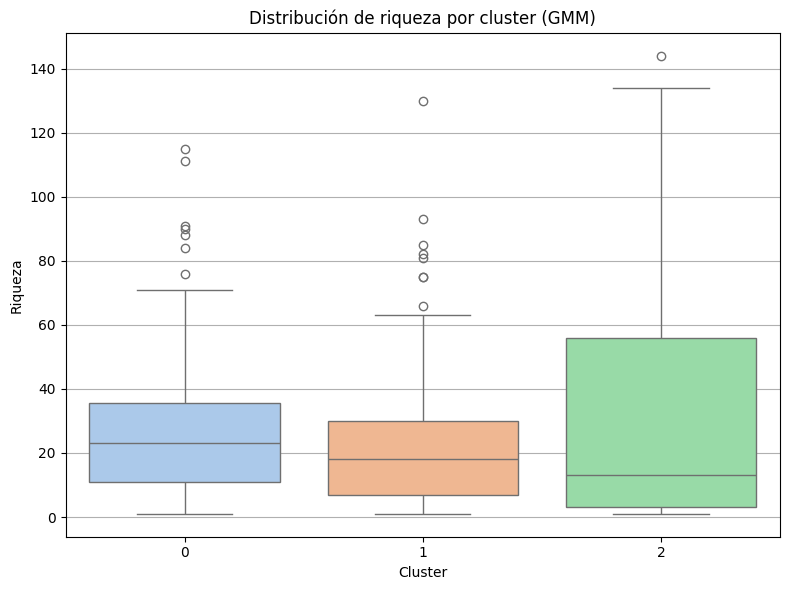

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cluster', y='riqueza', hue='cluster', palette='pastel', legend=False)
plt.title('Distribución de riqueza por cluster (GMM)')
plt.xlabel('Cluster')
plt.ylabel('Riqueza')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Se observa que la riqueza específica es similar entre los tres clusters del modelo

#### Celdas por cluster

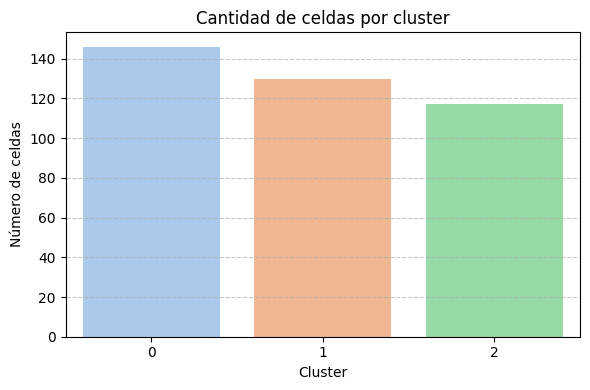

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='cluster', hue='cluster', palette='pastel', legend=False)
plt.title('Cantidad de celdas por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de celdas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se observa que los tres clusters tienen un tamaño similar, siendo el primero algo más grande.

## Exportar grilla espacial con los resultados de los modelos
Para permitir la visualización en el mapa

In [22]:
# Preparar los datos para la grilla espacial
clusters = labels_gmm
nombre_modelo = 'GaussianMixture'

In [23]:
# Agregar el resultado del modelo a la grilla espacial
gdf_grid = utils.grillar_res_mod(
    grilla=gdf_grid,
    id_grid=id_grid,
    clusters=clusters,
    nombre=nombre_modelo
)

In [24]:
# Guardo el resultado en un nuevo .gpkg
ruta_salida = "../data/processed/grilla_tdf_clusters.gpkg"
gdf_grid.to_file(ruta_salida, driver="GPKG", layer="grilla_clusters")

print("Grilla con clusters guardada en:", ruta_salida)

Grilla con clusters guardada en: ../data/processed/grilla_tdf_clusters.gpkg


La grilla espacial obtenida luego del modelado se continua procesando en el notebook 04-postprocesamiento